In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

In [ ]:
data = pd.read_excel('/content/Customer_Online_Transaction_data.xlsx')

In [ ]:
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df.duplicated().sum()

5268

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [ ]:
df['Total_cost'] = df['UnitPrice'] * df['Quantity']

In [ ]:
df = df.assign(CustomerID_isna = df['CustomerID'].isnull())
df['CustomerID_isna'] = df['CustomerID_isna'].astype('int64')
df = df.assign(Description_isna = df['Description'].isnull())
df['Description_isna'] = df['Description_isna'].astype('int64')

In [ ]:
df['CustomerID']=df.groupby(['Country','InvoiceNo'])['CustomerID'].ffill().bfill()

In [ ]:
df['Description'] = df['Description'].fillna("Unkown")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         536641 non-null  object        
 1   StockCode         536641 non-null  object        
 2   Description       536641 non-null  object        
 3   Quantity          536641 non-null  int64         
 4   InvoiceDate       536641 non-null  datetime64[ns]
 5   UnitPrice         536641 non-null  float64       
 6   CustomerID        536641 non-null  float64       
 7   Country           536641 non-null  object        
 8   Total_cost        536641 non-null  float64       
 9   CustomerID_isna   536641 non-null  int64         
 10  Description_isna  536641 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 49.1+ MB


In [ ]:
now = dt.date(2011,12,9)
df['InvoiceDate'] = pd.DatetimeIndex(df.InvoiceDate).date
df['Recency'] = df.InvoiceDate.apply(lambda x : (now - x).days)

In [ ]:
frequency_df = df.copy()
frequency_df.drop_duplicates(subset=['CustomerID','InvoiceNo'], inplace=True)
frequency_df = frequency_df.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
df = df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')

In [ ]:
monetary_df=df.groupby('CustomerID',as_index=False)['Total_cost'].sum()
monetary_df.columns = ['CustomerID','Monetary']
df = df.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_cost,CustomerID_isna,Description_isna,Recency,Frequency,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,0,0,373,35,5303.48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,0,0,373,35,5303.48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,0,0,373,35,5303.48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,0,0,373,35,5303.48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,0,0,373,35,5303.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536636,581578,22993,SET OF 4 PANTRY JELLY MOULDS,12,2011-12-09,1.25,12713.0,Germany,15.00,0,0,0,1,848.55
536637,581578,22907,PACK OF 20 NAPKINS PANTRY DESIGN,12,2011-12-09,0.85,12713.0,Germany,10.20,0,0,0,1,848.55
536638,581578,22908,PACK OF 20 NAPKINS RED APPLES,12,2011-12-09,0.85,12713.0,Germany,10.20,0,0,0,1,848.55
536639,581578,23215,JINGLE BELL HEART ANTIQUE SILVER,12,2011-12-09,2.08,12713.0,Germany,24.96,0,0,0,1,848.55


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df[['Recency','Frequency','Monetary']])
df['cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df['cluster'].unique()
df[df.cluster == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_cost,CustomerID_isna,Description_isna,Recency,Frequency,Monetary,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,0,0,373,35,5303.48,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,0,0,373,35,5303.48,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,0,0,373,35,5303.48,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,0,0,373,35,5303.48,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,0,0,373,35,5303.48,0


<Axes: >

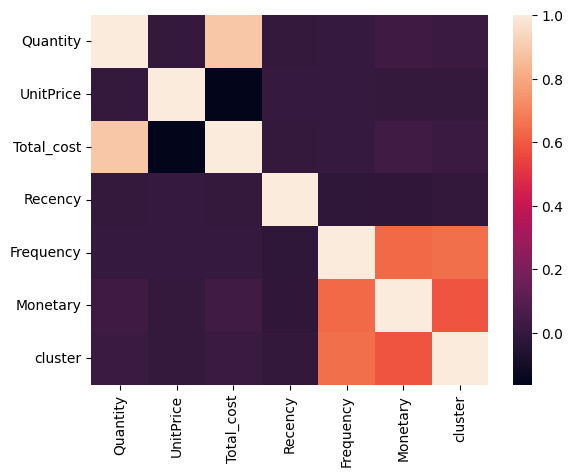

In [ ]:
sns.heatmap(df[['Quantity','UnitPrice','Total_cost','Recency','Frequency','Monetary', 'cluster']].corr())

<Axes: xlabel='Country', ylabel='Total_cost'>

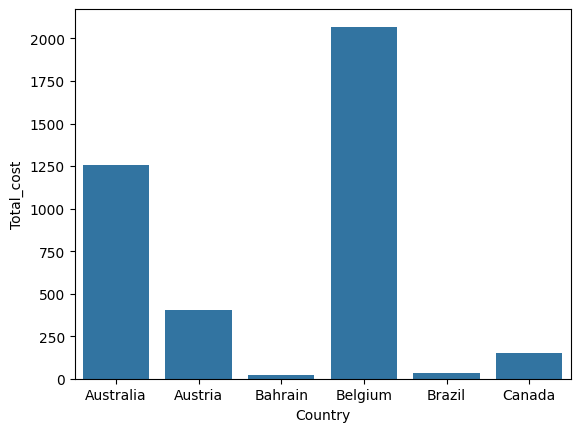

In [ ]:
df2 = df.groupby('Country',as_index=False)['Total_cost'].count()
df2 = df2.head(6)
sns.barplot(x='Country',y='Total_cost',data=df2)

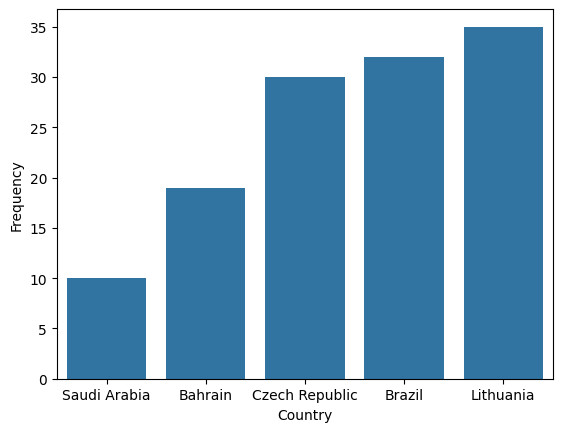

In [ ]:
df2 = df.groupby('Country',as_index=False)['Frequency'].count()
df2 = df2.sort_values('Frequency').head()#ascending=False
sns.barplot(x='Country',y='Frequency',data=df2);

<Axes: xlabel='cluster', ylabel='Recency'>

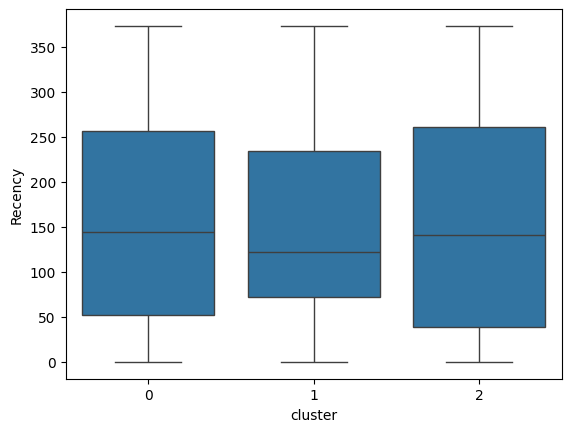

In [ ]:
sns.boxplot(data=df, x='cluster', y='Recency')

<Axes: xlabel='cluster', ylabel='Frequency'>

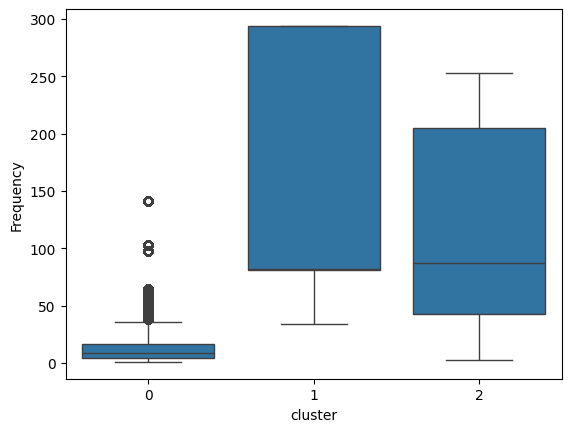

In [ ]:
sns.boxplot(data=df, x='cluster', y='Frequency')

<Axes: xlabel='cluster', ylabel='Monetary'>

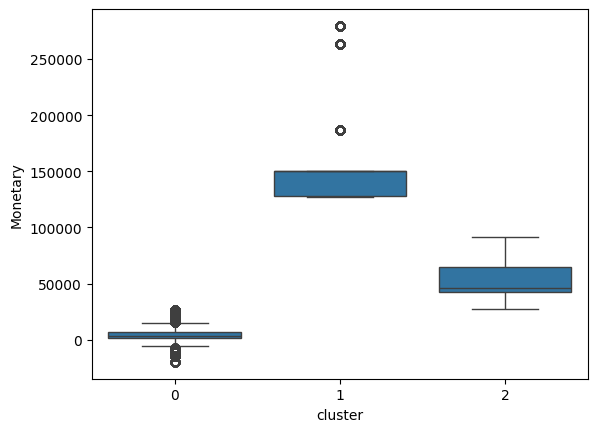

In [ ]:
sns.boxplot(data=df, x='cluster', y='Monetary')

In [ ]:
df2 = df[['Quantity','UnitPrice','Country','Total_cost','Recency','Frequency','Monetary', 'cluster']]
label_encoder = LabelEncoder()
df2['Country'] = label_encoder.fit_transform(df2['Country'])

column_names = df2.columns

scaled_data = MinMaxScaler().fit_transform(df2)

df2 = pd.DataFrame(scaled_data, columns=column_names)
df2.info()
df3 = df2[['Quantity','Country','Total_cost', 'cluster']]
df4 = df2[['Quantity','Total_cost','UnitPrice']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536641 entries, 0 to 536640
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Quantity    536641 non-null  float64
 1   UnitPrice   536641 non-null  float64
 2   Country     536641 non-null  float64
 3   Total_cost  536641 non-null  float64
 4   Recency     536641 non-null  float64
 5   Frequency   536641 non-null  float64
 6   Monetary    536641 non-null  float64
 7   cluster     536641 non-null  float64
dtypes: float64(8)
memory usage: 32.8 MB


<ipython-input-29-ce4f6ead89b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Country'] = label_encoder.fit_transform(df2['Country'])


# Monetary

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df2.drop('Monetary', axis=1),df2['Monetary'], test_size=0.10, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.005651511457214292
R-squared: 0.49075485230446914


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cross_val_results = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

cross_val_results

array([0.00581882, 0.00560096, 0.00533214, 0.00578155, 0.00529359,
       0.00592776, 0.00557039, 0.00551279, 0.00581928, 0.0058092 ])

# cluster

In [ ]:
df3 = df[['Quantity','Country','Total_cost', 'cluster']]
label_encoder = LabelEncoder()
df3['Country'] = label_encoder.fit_transform(df3['Country'])
#column_names = df3.columns

#scaled_data = MinMaxScaler().fit_transform(df3)

#df3 = pd.DataFrame(scaled_data, columns=column_names)

<ipython-input-32-e7d575322bfe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Country'] = label_encoder.fit_transform(df3['Country'])


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df3.drop('cluster', axis=1),df3['cluster'], test_size=0.10, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.336625361036057
R-squared: -0.03683357428337586


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cross_val_results = -cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

cross_val_results

array([0.03358123, 0.04091505, 0.04273858, 0.03734805, 0.03607363])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df3.drop('cluster', axis=1),df3['cluster'], test_size=0.20, random_state=42)
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.3448462204995854
R-squared: -0.07557930481593411


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cross_val_results = -cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

cross_val_results

array([0.07594475, 0.077676  , 0.08085592, 0.07873293, 0.0778212 ])

In [ ]:
#kf = KFold(n_splits=10, shuffle=True, random_state=42)

#cross_val_results = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

#cross_val_results

# Quantity

In [ ]:
df4 = df[['Quantity','UnitPrice','Total_cost','Monetary', 'cluster']]
label_encoder = LabelEncoder()
#df4['Country'] = label_encoder.fit_transform(df4['Country'])
#column_names = df4.columns

#scaled_data = MinMaxScaler().fit_transform(df4)

#df4 = pd.DataFrame(scaled_data, columns=column_names)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df4.drop('Quantity', axis=1),df4['Quantity'], test_size=0.10, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 4145.032919246585
R-squared: -1.5016943839559906


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cross_val_results = -cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

cross_val_results

array([ 0.19445519,  0.37289921, -0.92087151, -0.02879231,  0.19084506,
        0.54284414,  0.19261615, -0.9328493 , -0.67423292, -0.7440122 ])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df4.drop('Quantity', axis=1),df4['Quantity'], test_size=0.10, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 383.43533993243824
R-squared: 0.7685813224630333


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cross_val_results = -cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

cross_val_results

array([-0.55195413, -0.31259603, -0.83800862, -0.7537566 , -0.74805307,
       -0.75418324, -0.600808  , -0.78077964, -0.07578933, -0.07002878])

In [ ]:
df4.head()

,Quantity,UnitPrice,Total_cost,Monetary,cluster
0,6,2.55,15.30,5303.48,0
1,6,3.39,20.34,5303.48,0
2,8,2.75,22.00,5303.48,0
3,6,3.39,20.34,5303.48,0
4,6,3.39,20.34,5303.48,0
